In [3]:
import pandas as pd 
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Creating a Neural Network Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

/home/martin/anaconda3/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.4) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [5]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [6]:
# from google.colab import files
# uploaded = files.upload()

In [7]:
# BASEDIR = '/content/gdrive/MyDrive/tools4f/'  # colab
BASEDIR = '../../data/'  # jupyter

In [8]:
SEED = 420

# Load preprocessed data

In [9]:
# df = pd.read_pickle(BASEDIR + 'df_merged_train_test.pickle')
df = pd.read_pickle(BASEDIR + 'df_merged_train_test_all_base_scen.pickle')

X_train = df[0]
y_train = df[1]
X_test = df[2]
y_test = df[3]

X_train.frequency = X_train.frequency.astype('int8')
X_train.sum_ins = X_train.sum_ins.astype('int8')
X_train.pol_period = X_train.pol_period.astype('int8')
X_train.sex = X_train.sex.astype('int8')
X_train.entry_age = X_train.entry_age.astype('int8')
X_train.cnt_months = X_train.cnt_months.astype('int8')

X_test.frequency = X_test.frequency.astype('int8')
X_test.sum_ins = X_test.sum_ins.astype('int8')
X_test.pol_period = X_test.pol_period.astype('int8')
X_test.sex = X_test.sex.astype('int8')
X_test.entry_age = X_test.entry_age.astype('int8')
X_test.cnt_months = X_test.cnt_months.astype('int8')

In [10]:
print('# Train samples:', len(X_train))
print('# Test samples:', len(X_test))

# Train samples: 26295360
# Test samples: 6573840


## Optional: Pick smaller data for training

In [11]:
xy_train = pd.concat([X_train, y_train], axis=1)
xy_train_subset = xy_train.sample(frac=0.1, replace = False, random_state = np.random.RandomState())

In [12]:
y_train = xy_train_subset.pv_cf_rdr
X_train = xy_train_subset.drop(columns=['pv_cf_rdr'])

## Pick validation data

In [13]:
# first divison - train, validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, train_size=0.8, test_size=0.2, random_state=SEED)

In [14]:
print('# Train samples:', len(X_train))
print('# Val samples:  ', len(X_val))
print('# Test samples: ', len(X_test))

# Train samples: 2103628
# Val samples:   525908
# Test samples:  6573840


# One Hot Encoding

In [15]:
# Get one hot encoding
dummies_train = pd.get_dummies(X_train['frequency'])
dummies_val = pd.get_dummies(X_val['frequency'])
dummies_test = pd.get_dummies(X_test['frequency'])

In [16]:
dummies_train.columns = ['frequency_1', 'frequency_2', 'frequency_4', 'frequency_11', 'frequency_12']
dummies_val.columns = ['frequency_1', 'frequency_2', 'frequency_4', 'frequency_11', 'frequency_12']
dummies_test.columns = ['frequency_1', 'frequency_2', 'frequency_4', 'frequency_11', 'frequency_12']

In [17]:
# Drop encoded column
X_train = X_train.drop('frequency', axis=1)
X_val = X_val.drop('frequency', axis=1)
X_test = X_test.drop('frequency', axis=1)

In [18]:
# Join the encoded
X_train = X_train.join(dummies_train)
X_val = X_val.join(dummies_val)
X_test = X_test.join(dummies_test)

In [19]:
X_train

,sum_ins,pol_period,sex,entry_age,cv_ps_0,beta0,beta1,beta2,tau,cnt_months,frequency_1,frequency_2,frequency_4,frequency_11,frequency_12
9422933,32,50,0,20,1191.638450,0.025207,-0.036210,0.086088,4.229921,119,0,1,0,0,0
1468387,64,30,1,30,104.982025,0.037624,-0.053862,0.093040,2.259578,17,0,0,0,0,1
13950641,64,30,1,20,4593.701288,0.010904,-0.023544,0.073189,5.500312,119,0,0,1,0,0
25114439,32,10,1,60,3377.892995,0.008547,-0.034580,0.069839,2.574020,65,0,1,0,0,0
29852472,64,10,1,50,1254.083370,0.018222,-0.008097,0.034318,6.122767,29,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18742205,32,10,1,30,0.000000,0.004696,-0.018499,0.050853,5.001052,5,0,0,1,0,0
32191737,-96,10,0,50,0.000000,0.014899,0.006919,-0.035794,7.770390,11,1,0,0,0,0
9403299,64,10,1,40,2424.369514,0.022963,-0.036205,0.104970,5.255113,41,0,0,1,0,0
26539709,64,10,1,60,6755.785990,0.015162,-0.026933,0.058241,3.428346,71,0,0,1,0,0


# Optional: Standardize data

In [20]:
X_train_toscale = X_train[['sum_ins', 'pol_period', 'entry_age', 'beta0', 'beta1', 'beta2', 'tau', 'cv_ps_0', 'cnt_months']]
X_val_toscale = X_val[['sum_ins', 'pol_period', 'entry_age', 'beta0', 'beta1', 'beta2', 'tau', 'cv_ps_0', 'cnt_months']]
X_test_toscale = X_test[['sum_ins', 'pol_period', 'entry_age', 'beta0', 'beta1', 'beta2', 'tau', 'cv_ps_0', 'cnt_months']]

In [21]:
X_train_nottoscale = X_train[['sex', 'frequency_1', 'frequency_2', 'frequency_4', 'frequency_11', 'frequency_12']]
X_val_nottoscale = X_val[['sex', 'frequency_1', 'frequency_2', 'frequency_4', 'frequency_11', 'frequency_12']]
X_test_nottoscale = X_test[['sex', 'frequency_1', 'frequency_2', 'frequency_4', 'frequency_11', 'frequency_12']]

In [22]:
standard_scaler = StandardScaler()

X_train_scaled = pd.DataFrame(
    standard_scaler.fit_transform(X_train_toscale), columns=X_train_toscale.columns, index=X_train_toscale.index)
X_val_scaled = pd.DataFrame(
    standard_scaler.transform(X_val_toscale), columns=X_val_toscale.columns, index=X_val_toscale.index)
X_test_scaled = pd.DataFrame(
    standard_scaler.transform(X_test_toscale), columns=X_test_toscale.columns, index=X_test_toscale.index)

In [23]:
X_train = pd.concat([X_train_scaled, X_train_nottoscale], axis=1)
X_val = pd.concat([X_val_scaled, X_val_nottoscale], axis=1)
X_test = pd.concat([X_test_scaled, X_test_nottoscale], axis=1)

# Basic regression NN

In [25]:
model_1 = Sequential()
model_1.add(Dense(16, activation='relu', input_shape=(15,)))
model_1.add(Dense(1000, activation='relu'))
model_1.add(Dense(1))
model_1.compile(optimizer='Adam', loss='mse')

In [26]:
%%time
history_1 = model_1.fit(
    x=X_train,
    y=y_train,
    validation_split=0.25,
    batch_size=256,
    epochs=5,
    initial_epoch=0,
)
model_1.summary()

Epoch 1/5
6163/6163 [==============================] - 17s 3ms/step - loss: 7397929472.0000 - val_loss: 942257792.0000
Epoch 2/5
6163/6163 [==============================] - 16s 3ms/step - loss: 598596480.0000 - val_loss: 249530432.0000
Epoch 3/5
6163/6163 [==============================] - 19s 3ms/step - loss: 187624768.0000 - val_loss: 144741040.0000
Epoch 4/5
6163/6163 [==============================] - 17s 3ms/step - loss: 118843048.0000 - val_loss: 101929752.0000
Epoch 5/5
6163/6163 [==============================] - 17s 3ms/step - loss: 91386832.0000 - val_loss: 84616336.0000
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                256       
_________________________________________________________________
dense_4 (Dense)              (None, 1000)              17000     
___________________________________________________________

## Evaluation

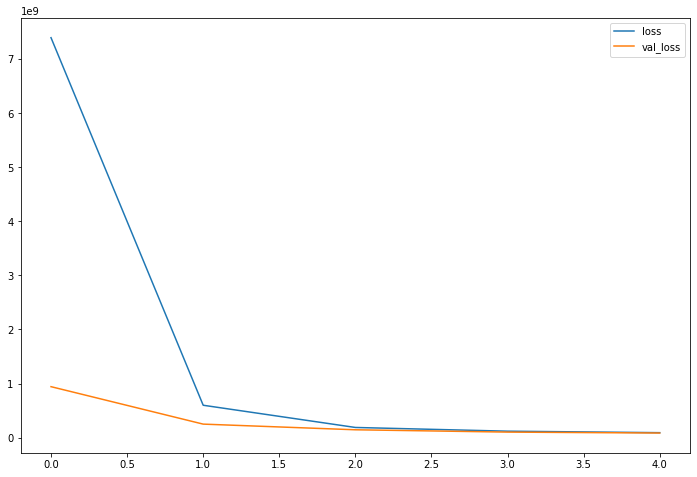

In [27]:
loss_df = pd.DataFrame(history_1.history)
loss_df.plot(figsize=(12,8))

In [28]:
%%time
y_pred_train = model_1.predict(X_train)
print('Train MAPE:', metrics.mean_absolute_percentage_error(y_train, y_pred_train)*100)

Train MAPE: 48.29317724894983
CPU times: user 28.4 s, sys: 2.95 s, total: 31.4 s
Wall time: 20.5 s


In [29]:
%%time
y_pred_val = model_1.predict(X_val)
print('Val MAPE:', metrics.mean_absolute_percentage_error(y_val, y_pred_val)*100)

Val MAPE: 114.21644150972104
CPU times: user 6.74 s, sys: 604 ms, total: 7.35 s
Wall time: 4.56 s


In [30]:
print('MAE:', metrics.mean_absolute_error(y_val, y_pred_val))  
print('MSE:', metrics.mean_squared_error(y_val, y_pred_val))  
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_val, y_pred_val)))
print('VarScore:',metrics.explained_variance_score(y_val, y_pred_val))

MAE: 5613.071994338869
MSE: 83631606.44487777
RMSE: 9145.031790260642
VarScore: 0.9974363582741496


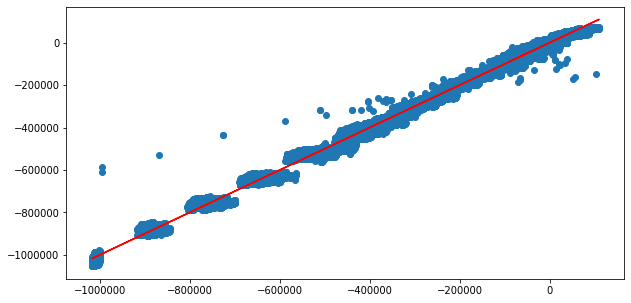

In [31]:
# Visualizing Our predictions
fig = plt.figure(figsize=(10,5))
plt.scatter(y_val,y_pred_val)
# Perfect predictions
plt.plot(y_val,y_val,'r')

In [51]:
y_val

24427982    -24380.051648
22554371    -80279.776314
5741771     -63667.231390
11625291    -33990.284520
13380776    -85287.318642
                ...      
25185608    -46483.049387
11174461   -377834.817878
26879691    -80094.616728
29496968    -51482.161813
7603408     -88094.570647
Name: pv_cf_rdr, Length: 525908, dtype: float64

In [60]:
y_pred_val

array([[-20757.416],
       [-78208.875],
       [-64072.004],
       ...,
       [-81976.09 ],
       [-51515.344],
       [-88853.266]], dtype=float32)

In [69]:
pd.DataFrame(y_val)

,pv_cf_rdr
24427982,-24380.051648
22554371,-80279.776314
5741771,-63667.231390
11625291,-33990.284520
13380776,-85287.318642
...,...
25185608,-46483.049387
11174461,-377834.817878
26879691,-80094.616728
29496968,-51482.161813


In [68]:
pd.DataFrame([item for sublist in y_pred_val for item in sublist])

,0
0,-20757.416016
1,-78208.875000
2,-64072.003906
3,-35283.257812
4,-83192.500000
...,...
525903,-45327.820312
525904,-386084.843750
525905,-81976.093750
525906,-51515.343750


In [108]:
result = pd.DataFrame()

In [109]:
a = pd.DataFrame(y_val)
index = a.index
b = pd.DataFrame([item for sublist in y_pred_val for item in sublist])

a.reset_index(drop=True, inplace=True)
b.reset_index(drop=True, inplace=True)

In [110]:
result['y_true'] = a
result['y_pred'] = b

In [112]:
result.set_index(index)

,y_true,y_pred
24427982,-24380.051648,-20757.416016
22554371,-80279.776314,-78208.875000
5741771,-63667.231390,-64072.003906
11625291,-33990.284520,-35283.257812
13380776,-85287.318642,-83192.500000
...,...,...
25185608,-46483.049387,-45327.820312
11174461,-377834.817878,-386084.843750
26879691,-80094.616728,-81976.093750
29496968,-51482.161813,-51515.343750
